In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-sentiment-analysis/news.csv


In [2]:
pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 66.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 112.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 672.8/672.8 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import re
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import mlflow

In [6]:
df=pd.read_csv('/kaggle/input/news-sentiment-analysis/news.csv')
df.head()


,date,news,neg,neu,pos,compound,sentiment
0,2007-07-07,It was a long antipodean night. While there’s ...,0.059000,0.87800,0.064000,0.051600,POSITIVE
1,2007-07-07,In Mexico there are no licensing or registrati...,0.044000,0.95600,0.000000,-0.296000,NEGATIVE
2,2007-07-07,The government has until Monday to protect the...,0.000000,0.89400,0.106000,0.381800,POSITIVE
3,2007-07-07,A record-breaking heat wave in the Southwest i...,0.197505,0.66149,0.141005,0.997491,POSITIVE
4,2007-07-07,England started its Live Earth concert at Wemb...,0.033000,0.94500,0.022000,-0.177900,NEGATIVE


In [7]:
# Enable MLflow autologging
mlflow.tensorflow.autolog()

In [8]:
df['sentiment'].value_counts()

sentiment
NEGATIVE    217443
POSITIVE    210039
Name: count, dtype: int64

In [9]:
# Check for missing values
print(df.isnull().sum())

date         0
news         0
neg          0
neu          0
pos          0
compound     0
sentiment    0
dtype: int64


In [10]:
# Check for duplicate headlines
print(f"Duplicates: {df.duplicated().sum()}")

Duplicates: 0


In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df.shape

(427482, 7)

In [13]:
# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])
    return text.strip()

In [14]:
df["clean_news"] = df["news"].apply(clean_text)
df.drop(columns=["news"], inplace=True)

In [15]:
# Define Financial Keywords
financial_keywords_positive = [
    "profits", "growth", "investment", "stock rise", "economic stimulus", "bull market",
    "revenue increase", "earnings beat", "expansion", "merger", "acquisition", "dividends",
    "IPO", "venture capital", "funding round", "market surge", "record high", "economic boom",
    "strong earnings", "recovery", "job creation"
]

financial_keywords_negative = [
    "inflation", "collapse", "recession", "bankruptcy", "debt", "bear market",
    "stock crash", "economic downturn", "losses", "default", "layoffs", "credit crisis",
    "interest rate hike", "market drop", "trade war", "stagflation", "credit downgrade",
    "federal reserve tightening", "slowdown", "budget deficit", "job cuts"
]

def calculate_financial_importance(news_text):
    pos_score = sum(1 for word in financial_keywords_positive if word in news_text)
    neg_score = sum(-1 for word in financial_keywords_negative if word in news_text)
    return pos_score + neg_score

# Apply Financial Importance Score
df['financial_importance'] = df['clean_news'].apply(calculate_financial_importance)

# Ranking System
df["rank_score"] = (df["pos"] * 2) + (df["neu"] * 1) - (df["neg"] * 3) + (df["compound"] * 5) + (df["financial_importance"] * 10)
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define the percentile range for clipping
lower_bound, upper_bound = np.percentile(df["rank_score"], [5, 95])

# Clip out extreme values
df["rank_score_clipped"] = df["rank_score"].clip(lower=lower_bound, upper=upper_bound)

# Apply Min-Max Scaling to (-10, 10)
scaler = MinMaxScaler(feature_range=(-10, 10))
df["rank_scaled"] = scaler.fit_transform(df[["rank_score_clipped"]])

# Convert to integers for clean ranking
df["rank_scaled"] = df["rank_scaled"].round().astype(int)

In [16]:
df.head()

,date,neg,neu,pos,compound,sentiment,clean_news,financial_importance,rank_score,rank_score_clipped,rank_scaled
0,2007-07-07,0.059000,0.87800,0.064000,0.051600,POSITIVE,long antipodean night theres telling whats ref...,0,1.087000,1.087000,0
1,2007-07-07,0.044000,0.95600,0.000000,-0.296000,NEGATIVE,mexico licensing registration requirements rea...,0,-0.656000,-0.656000,-3
2,2007-07-07,0.000000,0.89400,0.106000,0.381800,POSITIVE,government monday protect redacted names baseb...,0,3.015000,3.015000,4
3,2007-07-07,0.197505,0.66149,0.141005,0.997491,POSITIVE,recordbreaking heat wave southwest pushing nor...,0,5.338441,5.338441,8
4,2007-07-07,0.033000,0.94500,0.022000,-0.177900,NEGATIVE,england started live earth concert wembley sta...,0,0.000500,0.000500,-2


In [17]:
df["rank_scaled"].value_counts()

rank_scaled
 10    41720
 9     32940
 4     31126
 5     30838
 7     27644
-10    27030
 6     26256
 8     25870
 3     20007
-4     18626
-5     17353
-6     16831
-7     16230
-8     14793
-3     14774
 2     14037
-9     13099
 1     11738
-2     10698
-1      8440
 0      7432
Name: count, dtype: int64

In [18]:
df=df.drop(columns=['rank_score','rank_score_clipped','financial_importance'])
df.head()

,date,neg,neu,pos,compound,sentiment,clean_news,rank_scaled
0,2007-07-07,0.059000,0.87800,0.064000,0.051600,POSITIVE,long antipodean night theres telling whats ref...,0
1,2007-07-07,0.044000,0.95600,0.000000,-0.296000,NEGATIVE,mexico licensing registration requirements rea...,-3
2,2007-07-07,0.000000,0.89400,0.106000,0.381800,POSITIVE,government monday protect redacted names baseb...,4
3,2007-07-07,0.197505,0.66149,0.141005,0.997491,POSITIVE,recordbreaking heat wave southwest pushing nor...,8
4,2007-07-07,0.033000,0.94500,0.022000,-0.177900,NEGATIVE,england started live earth concert wembley sta...,-2


In [19]:
# Encode labels
label_mapping = {"NEGATIVE": 0, "POSITIVE": 1}
df["label"] = df["sentiment"].map(label_mapping)
df.drop(columns=["sentiment"], inplace=True)
df.head()

,date,neg,neu,pos,compound,clean_news,rank_scaled,label
0,2007-07-07,0.059000,0.87800,0.064000,0.051600,long antipodean night theres telling whats ref...,0,1
1,2007-07-07,0.044000,0.95600,0.000000,-0.296000,mexico licensing registration requirements rea...,-3,0
2,2007-07-07,0.000000,0.89400,0.106000,0.381800,government monday protect redacted names baseb...,4,1
3,2007-07-07,0.197505,0.66149,0.141005,0.997491,recordbreaking heat wave southwest pushing nor...,8,1
4,2007-07-07,0.033000,0.94500,0.022000,-0.177900,england started live earth concert wembley sta...,-2,0


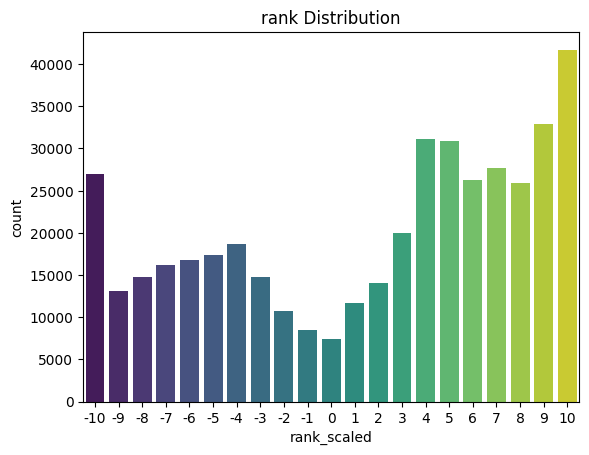

In [20]:
# Visualization
sns.countplot(x=df["rank_scaled"], palette="viridis")
plt.title("rank Distribution")
plt.show()

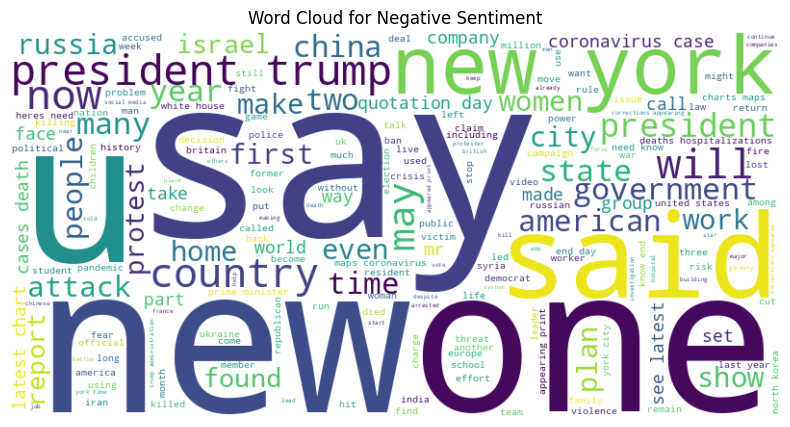

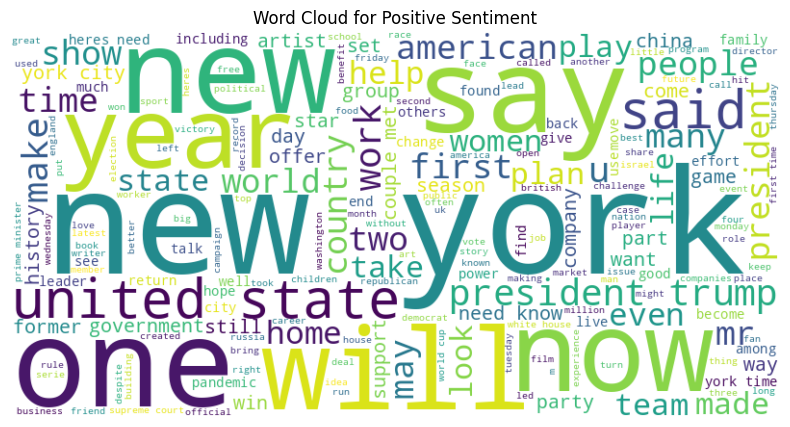

In [21]:
from wordcloud import WordCloud, STOPWORDS

# Define stopwords
stopwords = set(STOPWORDS)

# Generate and plot WordCloud for each sentiment
for sentiment, label in label_mapping.items():
    text = ' '.join(df[df["label"] == label]["clean_news"])

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=stopwords
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {sentiment.capitalize()} Sentiment")
    plt.show()


In [22]:
import mlflow
mlflow.tensorflow.autolog(log_models=True, log_datasets=False, disable_for_unsupported_versions=True)

In [23]:
import warnings
from huggingface_hub.utils import logging

# Suppress Hugging Face Hub warnings
warnings.filterwarnings("ignore", category=UserWarning, module="huggingface_hub")
logging.set_verbosity_error()

In [24]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text
def encode_text(texts, max_len=128):
    return tokenizer(
        texts.tolist(), 
        max_length=max_len, 
        truncation=True, 
        padding='max_length', 
        return_tensors='tf'
    )

encoded_data = encode_text(df["clean_news"])
input_ids = encoded_data['input_ids']
attention_mask = encoded_data['attention_mask']

# Prepare data for training
y_sentiment = df["label"].values
y_rank = df["rank_scaled"].values

X_train, X_test, y_train_sent, y_test_sent, y_train_rank, y_test_rank = train_test_split(
    input_ids.numpy(), y_sentiment, y_rank, test_size=0.2, random_state=42, stratify=y_sentiment
)

# Attention masks for train and test
train_mask, test_mask = train_test_split(
    attention_mask.numpy(), test_size=0.2, random_state=42)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [25]:
from transformers import TFBertModel

# Load pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Build Multi-Task Model with BERT
input_ids = tf.keras.Input(shape=(128,), dtype='int32')
attention_mask = tf.keras.Input(shape=(128,), dtype='int32')

bert_output = bert_model(input_ids, attention_mask=attention_mask)[1]  # Use pooled output

# Shared Representation
dense_1 = tf.keras.layers.Dense(64, activation="relu")(bert_output)
dropout = tf.keras.layers.Dropout(0.2)(dense_1)

# Task 1: Sentiment Analysis Output
sentiment_output = tf.keras.layers.Dense(1, activation="sigmoid", name="sentiment_output")(dropout)

# Task 2: Ranking Prediction Output
rank_output = tf.keras.layers.Dense(1, activation="linear", name="rank_output")(dropout)

# Define Model
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[sentiment_output, rank_output])

# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=2e-5),
    loss={"sentiment_output": "binary_crossentropy", "rank_output": "mse"},
    metrics={"sentiment_output": "accuracy", "rank_output": "mae"}
)

model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [26]:
# Early Stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

# Start MLflow Run
mlflow.set_experiment("Multi-Task Sentiment Analysis with BERT")
with mlflow.start_run():
    # Log model parameters
    mlflow.log_param("bert_model", "bert-base-uncased")
    mlflow.log_param("dropout", 0.2)
    mlflow.log_param("batch_size", 64)
    mlflow.log_param("epochs", 8)
    mlflow.log_param("optimizer", "AdamW")
    mlflow.log_param("learning_rate", 2e-5)

    # Disable automatic logging of TensorBoard events
    mlflow.tensorflow.autolog(every_n_iter=5,log_models=True,disable=True)  

    # Train Model
    history = model.fit(
        [X_train, train_mask], 
        {"sentiment_output": y_train_sent, "rank_output": y_train_rank},
        epochs=8,
        batch_size=64,
        validation_data=([X_test, test_mask], {"sentiment_output": y_test_sent, "rank_output": y_test_rank}),
        callbacks=callbacks)

2025/03/10 01:54:02 INFO mlflow.tracking.fluent: Experiment with name 'Multi-Task Sentiment Analysis with BERT' does not exist. Creating a new experiment.


Epoch 1/8
5344/5344 [==============================] - 5239s 973ms/step - loss: 14.8289 - sentiment_output_loss: 0.4658 - rank_output_loss: 14.3632 - sentiment_output_accuracy: 0.7730 - rank_output_mae: 2.7376 - val_loss: 11.5267 - val_sentiment_output_loss: 0.3693 - val_rank_output_loss: 11.1574 - val_sentiment_output_accuracy: 0.8353 - val_rank_output_mae: 2.1503
Epoch 2/8
5344/5344 [==============================] - 5199s 973ms/step - loss: 11.0084 - sentiment_output_loss: 0.3767 - rank_output_loss: 10.6317 - sentiment_output_accuracy: 0.8326 - rank_output_mae: 2.2024 - val_loss: 10.9451 - val_sentiment_output_loss: 0.3439 - val_rank_output_loss: 10.6012 - val_sentiment_output_accuracy: 0.8483 - val_rank_output_mae: 2.0550
Epoch 3/8
5344/5344 [==============================] - 5196s 972ms/step - loss: 9.4576 - sentiment_output_loss: 0.3512 - rank_output_loss: 9.1065 - sentiment_output_accuracy: 0.8467 - rank_output_mae: 2.0152 - val_loss: 11.7183 - val_sentiment_output_loss: 0.3468 

In [27]:
# Evaluate the model
    eval_results = model.evaluate(
        [X_test, test_mask], 
        {"sentiment_output": y_test_sent, "rank_output": y_test_rank}, 
        batch_size=64
    )

IndentationError: unexpected indent (<ipython-input-27-f29763569f49>, line 2)

In [ ]:
# Log evaluation results to MLflow
    mlflow.log_metric("sentiment_test_loss", eval_results[0])
    mlflow.log_metric("rank_test_loss", eval_results[1])
    mlflow.log_metric("sentiment_test_accuracy", eval_results[2])
    mlflow.log_metric("rank_test_mae", eval_results[3])

    # Save model to MLflow
    mlflow.tensorflow.log_model(model, "model")

    # Save model locally in Kaggle
    model.save("/kaggle/working/multi_task_bert_model.h5")

In [ ]:
# Print MLflow tracking URI
mlflow.set_tracking_uri("file:///kaggle/working/mlruns")
print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")